In [1]:
%matplotlib inline
import os
import gzip
import pickle
import glob
import datetime

from multiprocessing import Pool

import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

In [2]:
indir = "../saved_rca_rain/"
flist = sorted(glob.glob(os.path.join(indir, "*.nc")))

rca = np.array([])
rain = np.array([])
dtime = np.array([], dtype=np.datetime64)
for fd in flist:
    with netCDF4.Dataset(fd, 'r') as ncid:
        time = ncid['time'][:]
        rca_tmp = ncid['rca'][:]
        
        dtime_tmp = netCDF4.num2date(time, ncid['time'].units)
        rca = np.append(rca, rca_tmp)
        dtime = np.append(dtime, dtime_tmp)
        rain = np.append(rain, ncid["rain"][:])

In [3]:
rain[np.isnan(rain)] = 0
myrain = np.ma.masked_where(rain > 1, rain)
pos = ~myrain.mask
st, ed = np.min(dtime), np.max(dtime)

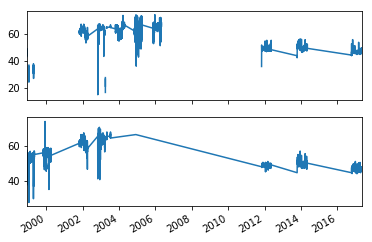

In [4]:
fig, ax = pl.subplots(2, 1, sharex=True)
ax = ax.flatten()
ax[0].plot(dtime[pos], rca[pos])
ax[0].set_xlim(st, ed)

ax[1].plot(dtime[~pos], rca[~pos])
ax[1].set_xlim(st, ed)
fig.autofmt_xdate()
pl.show()

In [5]:
with gzip.GzipFile("CPOL_RCA_1998-2017.pkl.gz", "r") as gzid:
    data = pickle.load(gzid)
    rca = data['RCA']
    dtime = data['dtime']

In [6]:
def get_rca(rca, dtime):
    pos = ((dtime >= datetime.datetime(2009, 1, 1)) & (dtime <= datetime.datetime(2015, 10, 1))) | ((dtime >= datetime.datetime(2016, 10, 1)) & (dtime <= datetime.datetime(2017, 10, 1)))
    myrca = rca
    myrca[pos] = myrca[pos] / 2 - 32
    
    df = pd.Series(data=rca, index=dtime)            
        
    rca_hourly = df.resample('1H').mean()
    rca_daily = df.resample('D').mean()
    
    return rca_hourly, rca_daily

In [7]:
rca_hourly, rca_daily = get_rca(rca, dtime)

In [8]:
time_hourly = rca_hourly.index
val_rcah = rca_hourly.values
time_daily = rca_daily.index
val_rcad = rca_daily.values

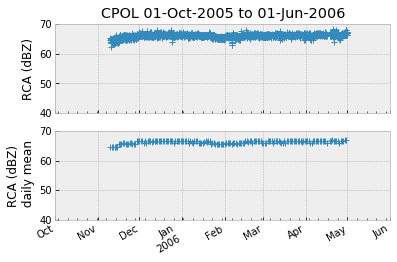

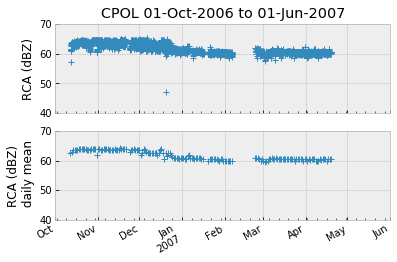

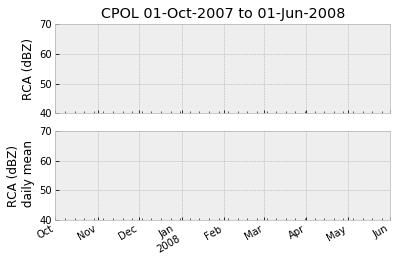

In [10]:
for ys in range(2005, 2008): # 2011, 2012, 2013, 2014, 2015, 2016]:
    st = datetime.datetime(ys, 10, 1)
    ed = datetime.datetime(ys+1, 6, 1)
    ylim = (42, 47)
    if ys == 2013 or ys <= 2000:
        ylim = (45, 60)
    elif ys <= 2007:
        ylim = (55, 70)        
    if ys == 2000:
        continue
    df = pd.Series(data=rca, index=dtime)                 
        
    meanval = df[(df.index > st) & (df.index < ed)].mean()
    
    with pl.style.context('bmh'):
        fig, myax = pl.subplots(2, 1, sharex=True)
        myax = myax.flatten()

        ao = df.resample('1H').median()
        ao.plot(style='+', ax=myax[0], label="10 min", )
        myax[0].set_ylabel('RCA (dBZ)')

        ao = df.resample('D').median()
        ao.plot(style='+', ax=myax[1], label="Daily mean")
        myax[1].set_ylabel("RCA (dBZ)\n daily mean")

        for lax in myax:
            lax.set_ylim((40, 70))
            lax.set_xlim((st, ed))

#             lax.legend()

        myax[0].set_title("CPOL {} to {}".format(st.strftime("%d-%b-%Y"), ed.strftime("%d-%b-%Y")))
        fig.autofmt_xdate()
        pl.show()
#         outfilename = "new_RCA_CPOL_season_{}{}.png".format(ys % 100, (ys + 1) % 100)
#         pl.savefig(outfilename, dpi=150)
#         pl.close()      

In [9]:
txt = """
#### s9899
datetime.datetime(1998, 12, 6), datetime.datetime(1999, 1, 16),   4.7
datetime.datetime(1999, 1, 17), datetime.datetime(1999, 1, 17),  23.4
datetime.datetime(1999, 1, 18), datetime.datetime(1999, 4, 17),   1.57
datetime.datetime(1999, 4, 18), datetime.datetime(1999, 4, 23),  19.0
datetime.datetime(1999, 4, 24), datetime.datetime(1999, 5, 31),   0

#### s9900
datetime.datetime(1999, 11, 4),  datetime.datetime(1999, 11, 12), 0
datetime.datetime(1999, 11, 13), datetime.datetime(1999, 12, 29), 5
datetime.datetime(1999, 12, 30), datetime.datetime(2000, 1, 6),   8.1
datetime.datetime(2000, 1, 7),   datetime.datetime(2000, 5, 31),  0

#### s0102
datetime.datetime(2001, 10, 2),  datetime.datetime(2001, 11, 25),  0 
datetime.datetime(2001, 11, 26), datetime.datetime(2001, 12, 2),  -2.5
datetime.datetime(2001, 12, 3),  datetime.datetime(2001, 12, 18), -0.5
datetime.datetime(2001, 12, 19), datetime.datetime(2002, 1, 9),   -2.2
datetime.datetime(2002, 1, 10),  datetime.datetime(2002, 1, 14),   0
datetime.datetime(2002, 1, 15),  datetime.datetime(2002, 2, 10),  -2.6
datetime.datetime(2002, 2, 11),  datetime.datetime(2002, 2, 16),   0
datetime.datetime(2002, 2, 17),  datetime.datetime(2002, 2, 21),  -1.7
datetime.datetime(2002, 2, 22),  datetime.datetime(2002, 3, 14),   3
datetime.datetime(2002, 3, 15),  datetime.datetime(2002, 3, 19),   1.6
datetime.datetime(2002, 3, 20),  datetime.datetime(2002, 4, 3),    2.3
datetime.datetime(2002, 4, 4),   datetime.datetime(2002, 4, 7),    3.4

#### s0203
datetime.datetime(2002, 10, 20), datetime.datetime(2002, 11, 4),   3.5
datetime.datetime(2002, 11, 5),  datetime.datetime(2003, 3, 17),   0
datetime.datetime(2003, 3, 18),  datetime.datetime(2003, 3, 30),   3.8
datetime.datetime(2003, 4, 1),   datetime.datetime(2003, 4, 8),   15.5
datetime.datetime(2003, 4, 9),   datetime.datetime(2003, 7, 14),  -0.6

#### s0304
datetime.datetime(2003, 10, 20), datetime.datetime(2003, 10, 21),  1.2
datetime.datetime(2003, 10, 22), datetime.datetime(2003, 10, 27),  4.3
datetime.datetime(2003, 10, 28), datetime.datetime(2003, 12, 3),   1.7
datetime.datetime(2003, 12, 4),  datetime.datetime(2003, 12, 12),  4.9 
datetime.datetime(2003, 12, 13), datetime.datetime(2003, 12, 26),  8
datetime.datetime(2003, 12, 27), datetime.datetime(2004, 2, 23),   7.2
datetime.datetime(2004, 2, 24),  datetime.datetime(2004, 3, 2),    6.2
datetime.datetime(2004, 3, 3),   datetime.datetime(2004, 5, 4),    0

#### s0405
datetime.datetime(2004, 11, 3),  datetime.datetime(2004, 11, 10),  5.3
datetime.datetime(2004, 11, 11),  datetime.datetime(2005, 11, 28),  0

#### s0506
datetime.datetime(2005, 11, 10),  datetime.datetime(2005, 11, 15),  1.6
datetime.datetime(2005, 11, 16),  datetime.datetime(2005, 11, 28),  0.4
datetime.datetime(2005, 11, 29),  datetime.datetime(2006, 5, 1),    0

#### s0607
datetime.datetime(2006, 10, 12),  datetime.datetime(2006, 12, 19), 0
datetime.datetime(2006, 12, 20),  datetime.datetime(2007, 4, 19),  3

#### s0910
datetime.datetime(2009, 11, 30),  datetime.datetime(2010, 5, 6),  0

#### s1011
datetime.datetime(2010, 11, 5),  datetime.datetime(2011, 4, 18),  0

#### s1112
datetime.datetime(2011, 11, 1),  datetime.datetime(2012, 5, 14),  0

#### s1213
datetime.datetime(2012, 11, 6),  datetime.datetime(2012, 11, 7),  1.5
datetime.datetime(2012, 11, 8),  datetime.datetime(2012, 11, 8),  -2.5
datetime.datetime(2012, 11, 9),  datetime.datetime(2012, 11, 12),  -3.5
datetime.datetime(2012, 11, 14),  datetime.datetime(2012, 11, 20),  -2.5
datetime.datetime(2012, 11, 22),  datetime.datetime(2013, 5, 6),  0

#### s1314
datetime.datetime(2013, 10, 15),  datetime.datetime(2013, 10, 17),  -0.5
datetime.datetime(2013, 10, 18),  datetime.datetime(2013, 11, 4),  -1.6
datetime.datetime(2013, 11, 5),  datetime.datetime(2014, 5, 7),  0

#### s1415
datetime.datetime(2014, 10, 24),  datetime.datetime(2014, 10, 30),  5
datetime.datetime(2014, 11, 10),  datetime.datetime(2015, 5, 31),  0

#### s1516
datetime.datetime(2015, 10, 6),  datetime.datetime(2015, 10, 7),  -2.5
datetime.datetime(2015, 10, 12),  datetime.datetime(2016, 4, 20),  0

#### s1617
datetime.datetime(2016, 10, 11),  datetime.datetime(2016, 10, 26),  2.0
datetime.datetime(2016, 10, 27),  datetime.datetime(2017, 5, 2),  0
"""

In [10]:
# mydate = [print("(" + l + "),") for l in txt.splitlines() if "datetime" in l]

In [11]:
mydate = [(datetime.datetime(1998, 12, 6), datetime.datetime(1999, 1, 16),   4.7),
(datetime.datetime(1999, 1, 17), datetime.datetime(1999, 1, 17),  23.4),
(datetime.datetime(1999, 1, 18), datetime.datetime(1999, 4, 17),   1.57),
(datetime.datetime(1999, 4, 18), datetime.datetime(1999, 4, 23),  19.0),
(datetime.datetime(1999, 4, 24), datetime.datetime(1999, 5, 31),   0),
(datetime.datetime(1999, 11, 4),  datetime.datetime(1999, 11, 12), 0),
(datetime.datetime(1999, 11, 13), datetime.datetime(1999, 12, 29), 5),
(datetime.datetime(1999, 12, 30), datetime.datetime(2000, 1, 6),   8.1),
(datetime.datetime(2000, 1, 7),   datetime.datetime(2000, 5, 31),  0),
(datetime.datetime(2001, 10, 2),  datetime.datetime(2001, 11, 25),  0 ),
(datetime.datetime(2001, 11, 26), datetime.datetime(2001, 12, 2),  -2.5),
(datetime.datetime(2001, 12, 3),  datetime.datetime(2001, 12, 18), -0.5),
(datetime.datetime(2001, 12, 19), datetime.datetime(2002, 1, 9),   -2.2),
(datetime.datetime(2002, 1, 10),  datetime.datetime(2002, 1, 14),   0),
(datetime.datetime(2002, 1, 15),  datetime.datetime(2002, 2, 10),  -2.6),
(datetime.datetime(2002, 2, 11),  datetime.datetime(2002, 2, 16),   0),
(datetime.datetime(2002, 2, 17),  datetime.datetime(2002, 2, 21),  -1.7),
(datetime.datetime(2002, 2, 22),  datetime.datetime(2002, 3, 14),   3),
(datetime.datetime(2002, 3, 15),  datetime.datetime(2002, 3, 19),   1.6),
(datetime.datetime(2002, 3, 20),  datetime.datetime(2002, 4, 3),    2.3),
(datetime.datetime(2002, 4, 4),   datetime.datetime(2002, 4, 7),    3.4),
(datetime.datetime(2002, 10, 20), datetime.datetime(2002, 11, 4),   3.5),
(datetime.datetime(2002, 11, 5),  datetime.datetime(2003, 3, 17),   0),
(datetime.datetime(2003, 3, 18),  datetime.datetime(2003, 3, 30),   3.8),
(datetime.datetime(2003, 4, 1),   datetime.datetime(2003, 4, 8),   15.5),
(datetime.datetime(2003, 4, 9),   datetime.datetime(2003, 7, 14),  -0.6),
(datetime.datetime(2003, 10, 20), datetime.datetime(2003, 10, 21),  1.2),
(datetime.datetime(2003, 10, 22), datetime.datetime(2003, 10, 27),  4.3),
(datetime.datetime(2003, 10, 28), datetime.datetime(2003, 12, 3),   1.7),
(datetime.datetime(2003, 12, 4),  datetime.datetime(2003, 12, 12),  4.9 ),
(datetime.datetime(2003, 12, 13), datetime.datetime(2003, 12, 26),  8),
(datetime.datetime(2003, 12, 27), datetime.datetime(2004, 2, 23),   7.2),
(datetime.datetime(2004, 2, 24),  datetime.datetime(2004, 3, 2),    6.2),
(datetime.datetime(2004, 3, 3),   datetime.datetime(2004, 5, 4),    0),
(datetime.datetime(2004, 11, 3),  datetime.datetime(2004, 11, 10),  5.3),
(datetime.datetime(2004, 11, 11),  datetime.datetime(2005, 11, 28),  0),
(datetime.datetime(2005, 11, 10),  datetime.datetime(2005, 11, 15),  1.6),
(datetime.datetime(2005, 11, 16),  datetime.datetime(2005, 11, 28),  0.4),
(datetime.datetime(2005, 11, 29),  datetime.datetime(2006, 5, 1),    0),
(datetime.datetime(2006, 10, 12),  datetime.datetime(2006, 12, 19), -3),
(datetime.datetime(2006, 12, 20),  datetime.datetime(2007, 4, 19),  0),
(datetime.datetime(2009, 11, 30),  datetime.datetime(2010, 5, 6),  0),
(datetime.datetime(2010, 11, 5),  datetime.datetime(2011, 4, 18),  0),
(datetime.datetime(2011, 11, 1),  datetime.datetime(2012, 5, 14),  0),
(datetime.datetime(2012, 11, 6),  datetime.datetime(2012, 11, 7),  1.5),
(datetime.datetime(2012, 11, 8),  datetime.datetime(2012, 11, 8),  -2.5),
(datetime.datetime(2012, 11, 9),  datetime.datetime(2012, 11, 12),  -3.5),
(datetime.datetime(2012, 11, 14),  datetime.datetime(2012, 11, 20),  -2.5),
(datetime.datetime(2012, 11, 22),  datetime.datetime(2013, 5, 6),  0),
(datetime.datetime(2013, 10, 15),  datetime.datetime(2013, 10, 17),  -0.5),
(datetime.datetime(2013, 10, 18),  datetime.datetime(2013, 11, 4),  -1.6),
(datetime.datetime(2013, 11, 5),  datetime.datetime(2014, 5, 7),  0),
(datetime.datetime(2014, 10, 24),  datetime.datetime(2014, 10, 30),  5),
(datetime.datetime(2014, 11, 10),  datetime.datetime(2015, 5, 31),  0),
(datetime.datetime(2015, 10, 6),  datetime.datetime(2015, 10, 7),  -2.5),
(datetime.datetime(2015, 10, 12),  datetime.datetime(2016, 4, 20),  0),
(datetime.datetime(2016, 10, 11),  datetime.datetime(2016, 10, 26),  2.0),
(datetime.datetime(2016, 10, 27),  datetime.datetime(2017, 5, 2),  0)]

In [12]:
def get_dr(onedate):
    rval = None
    for datest, dateed, rval in mydate:
        if (onedate >= datest) & (onedate <= dateed):
            break
    return rval

In [13]:
period_start = []
period_end = []
rca_value = []

for a, b, c in mydate:
    period_start.append(a)
    period_end.append(a)
    rca_value.append(a)
# mydate

In [14]:
with gzip.GzipFile("RCA_CPOL_AUG2017_VAL.pkl.gz", "w") as gzid:
    data = {"date_start": period_start, "date_end": period_end, "rca": rca_value}
    pickle.dump(data, gzid)

In [15]:
calib = [(datetime.datetime(1998, 12, 6), datetime.datetime(1999, 1, 16),   2.7),
(datetime.datetime(1999, 1, 17), datetime.datetime(1999, 1, 17),  21.4),
(datetime.datetime(1999, 1, 18), datetime.datetime(1999, 4, 17),   -0.5),
(datetime.datetime(1999, 4, 18), datetime.datetime(1999, 4, 23),  17.0),
(datetime.datetime(1999, 4, 24), datetime.datetime(1999, 5, 31),   -2.),
(datetime.datetime(1999, 11, 4),  datetime.datetime(1999, 11, 12), -4.40),
(datetime.datetime(1999, 11, 13), datetime.datetime(1999, 12, 29), 0.6),
(datetime.datetime(1999, 12, 30), datetime.datetime(2000, 1, 6),   3.7),
(datetime.datetime(2000, 1, 7),   datetime.datetime(2000, 5, 31),  -4.40),
(datetime.datetime(2001, 10, 2),  datetime.datetime(2001, 11, 25),  -1 ),
(datetime.datetime(2001, 11, 26), datetime.datetime(2001, 12, 2),  -3.5),
(datetime.datetime(2001, 12, 3),  datetime.datetime(2001, 12, 18), -1.5),
(datetime.datetime(2001, 12, 19), datetime.datetime(2002, 1, 9),   -3.2),
(datetime.datetime(2002, 1, 10),  datetime.datetime(2002, 1, 14),   -1),
(datetime.datetime(2002, 1, 15),  datetime.datetime(2002, 2, 10),  -3.6),
(datetime.datetime(2002, 2, 11),  datetime.datetime(2002, 2, 16),   -1),
(datetime.datetime(2002, 2, 17),  datetime.datetime(2002, 2, 21),  -2.7),
(datetime.datetime(2002, 2, 22),  datetime.datetime(2002, 3, 14),   2),
(datetime.datetime(2002, 3, 15),  datetime.datetime(2002, 3, 19),   0.6),
(datetime.datetime(2002, 3, 20),  datetime.datetime(2002, 4, 3),    1.3),
(datetime.datetime(2002, 4, 4),   datetime.datetime(2002, 4, 7),    2.4),
(datetime.datetime(2002, 10, 20), datetime.datetime(2002, 11, 4),   4.6),
(datetime.datetime(2002, 11, 5),  datetime.datetime(2003, 3, 17),   1.1),
(datetime.datetime(2003, 3, 18),  datetime.datetime(2003, 3, 30),   4.9),
(datetime.datetime(2003, 4, 1),   datetime.datetime(2003, 4, 8),   16.6),
(datetime.datetime(2003, 4, 9),   datetime.datetime(2003, 7, 14),  0.5),
(datetime.datetime(2003, 10, 20), datetime.datetime(2003, 10, 21),  1.9),
(datetime.datetime(2003, 10, 22), datetime.datetime(2003, 10, 27),  5.0),
(datetime.datetime(2003, 10, 28), datetime.datetime(2003, 12, 3),   2.4),
(datetime.datetime(2003, 12, 4),  datetime.datetime(2003, 12, 12),  5.6 ),
(datetime.datetime(2003, 12, 13), datetime.datetime(2003, 12, 26),  8.7),
(datetime.datetime(2003, 12, 27), datetime.datetime(2004, 2, 23),   7.9),
(datetime.datetime(2004, 2, 24),  datetime.datetime(2004, 3, 2),    6.9),
(datetime.datetime(2004, 3, 3),   datetime.datetime(2004, 5, 4),    0.7),
(datetime.datetime(2004, 11, 3),  datetime.datetime(2004, 11, 10),  6.4),
(datetime.datetime(2004, 11, 11),  datetime.datetime(2005, 11, 28),  1.1),
(datetime.datetime(2005, 11, 10),  datetime.datetime(2005, 11, 15),  2.7),
(datetime.datetime(2005, 11, 16),  datetime.datetime(2005, 11, 28),  1.5),
(datetime.datetime(2005, 11, 29),  datetime.datetime(2006, 5, 1),    1.1),
(datetime.datetime(2006, 10, 12),  datetime.datetime(2006, 12, 19), 0),
(datetime.datetime(2006, 12, 20),  datetime.datetime(2007, 4, 19),  3),
(datetime.datetime(2009, 11, 30),  datetime.datetime(2010, 5, 6),  -3.5),
(datetime.datetime(2010, 11, 5),  datetime.datetime(2011, 4, 18),  -3.7),
(datetime.datetime(2011, 11, 1),  datetime.datetime(2012, 5, 14),  -2.4),
(datetime.datetime(2012, 11, 6),  datetime.datetime(2012, 11, 7),  0),
(datetime.datetime(2012, 11, 8),  datetime.datetime(2012, 11, 8),  -4.3),
(datetime.datetime(2012, 11, 9),  datetime.datetime(2012, 11, 12),  -5.3),
(datetime.datetime(2012, 11, 14),  datetime.datetime(2012, 11, 20),  -4.3),
(datetime.datetime(2012, 11, 22),  datetime.datetime(2013, 5, 6),  -1.8),
(datetime.datetime(2013, 10, 15),  datetime.datetime(2013, 10, 17),  -2.5),
(datetime.datetime(2013, 10, 18),  datetime.datetime(2013, 11, 4),  -3.6),
(datetime.datetime(2013, 11, 5),  datetime.datetime(2014, 5, 7),  -2.0),
(datetime.datetime(2014, 10, 24),  datetime.datetime(2014, 10, 30),  4.2),
(datetime.datetime(2014, 11, 10),  datetime.datetime(2015, 5, 31),  -0.8),
(datetime.datetime(2015, 10, 6),  datetime.datetime(2015, 10, 7),  -5.5),
(datetime.datetime(2015, 10, 12),  datetime.datetime(2016, 4, 20),  -3),
(datetime.datetime(2016, 10, 11),  datetime.datetime(2016, 10, 26),  -0.5),
(datetime.datetime(2016, 10, 27),  datetime.datetime(2017, 5, 2),  -2.5),]

In [16]:
std, edd, cval = zip(*calib)

In [17]:
with gzip.GzipFile("CPOL_CALIBRATION.pkl.gz", "w") as gzid:
    data = {"period_start": std, "period_end": edd, "calibration_value": cval, "metadata": "Z_CALIBRATED = Z_CPOL + CALIBRATION_VALUE"}
    pickle.dump(data, gzid)